# Projections onto the canonical simplex with additional linear inequalities

This repository is a complementary material to our paper ["Projections onto the canonical simplex with additional linear inequalities"](https://arxiv.org/), where we consider projections coming from the fields of distributionally robust optimization (DRO1 and DRO2).

## Preliminaries

This notebook and the codes can be accessed without any installations. To change the codes, it is necessary to install [Julia](https://julialang.org/downloads/) (tested for version 1.2.0), the [Projection](https://github.com/VaclavMacha/Projections/tree/develop) package and some standard packages such as `Random` or `Plots`. The `Projection` package can be installed using pkg REPL as follows

```julia
(v1.2) pkg> add https://github.com/VaclavMacha/Projections.git#develop
```

After doing so, we load the packages and set the seed by running

In [1]:
using Projections
using Plots, Random, Distributions, LinearAlgebra

Random.seed!(12);

The `Projections` package provides three problems, namely (DRO1), (DRO2) and (Simplex). The last one is not presented in this notebook. The package also provides three different solvers:

1. `Sadda()`    - our solver
2. `General()`  - general purpose solvers such as [Ipopt](https://github.com/coin-or/Ipopt) or [CPLEX](https://www.ibm.com/products/ilog-cplex-optimization-studio)
3. `Philpott()` - algorithm presented in [[Philpott 2018]](https://link.springer.com/article/10.1007/s10287-018-0314-0) for the (DRO2) with l-2 norm

## 1. Problem (DRO1)

Problem (DRO1) stems from the distributinally robust optimization and reads

$$
\begin{align*}
    \mathrm{maximize}
        \quad & \mathbf{c}^\top \mathbf{p} \\
    \mathrm{subject\ to}
        \quad & \sum_{i=1}^n p_i=1, \\
        \quad & 0 \le p_i, \quad \forall i = 1, \dots, n,\\
        \quad & \sum_{i=1}^n q_i \phi\left(\frac{p_i}{q_i}\right) \le \varepsilon.
\end{align*}
$$

For the detailed problem derivation, please refer to our paper.

### 1.1. Solution properties

Since the problem does not depend on the order of the components of $\mathbf{p}$, without loss of generality we assume that $\mathbf{c}$ is sorted. First, we generate random data and then compute the optimal solution for problem (DRO1).

In [2]:
n = 20;
q = ones(n)/n;
c = sort(rand(Distributions.Normal(0,1), n));
ε = 0.05;

To check whether our solution is correct, we compare it with the solution given by the [Ipopt](https://www.coin-or.org/Ipopt/documentation/) or [CPLEX](https://www.ibm.com/products/ilog-cplex-optimization-studio) solver. To keep the presentation simple, we compare results only for (DRO1) with the Kullback-Leibler divergence, where we use the `Ipopt` solver.

In [3]:
p_our   = solve(Sadda(), DRO(KullbackLeibler(), q, c, ε));
p_ipopt = solve(General(), DRO(KullbackLeibler(), q, c, ε));

print(string("‖p_our - p_ipopt‖ = ", LinearAlgebra.norm(p_our .- p_ipopt)))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

‖p_our - p_ipopt‖ = 7.056173981310798e-9

Now we plot the obtained solutions for all five $\phi$-divergences. Since $\mathbf{p}$ is a probability distribution, an increase in one component has to lead to a decrease in another. Since the objective is linear and our aim is to maximize it, the solution will have small values of $p_i$ whenever $c_i$ is small and large values of $p_i$ whenever $c_i$ is large. This is shown in the next graph, where the values of the components of the vector $\mathbf{q}$ are denoted by blue circles and the values of the components of the optimal solution $\mathbf{p}$ are denoted by orange squares. Recall that $\mathbf{q}$ follows the uniform distribution and that $\mathbf{c}$ is sorted.

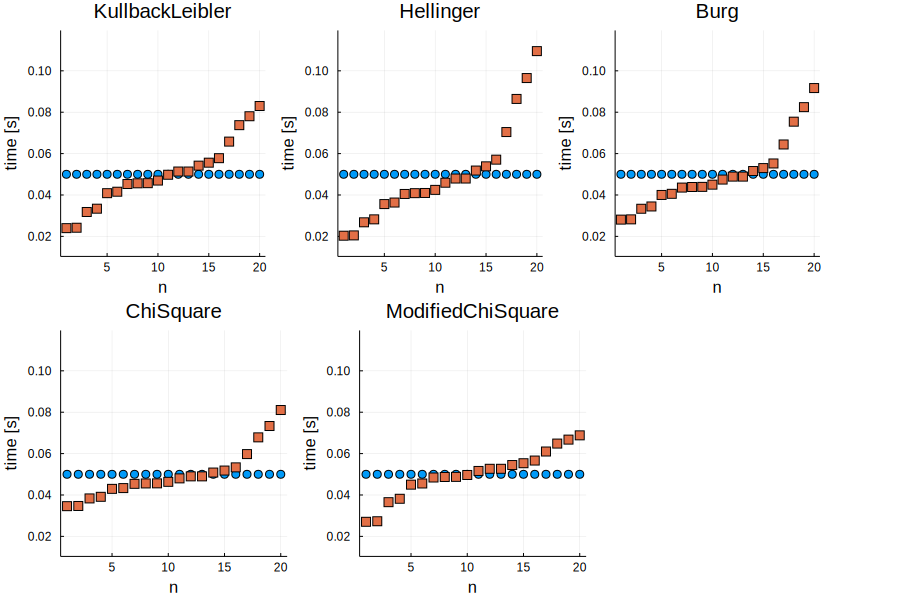

In [4]:
y_lims = Float64[]
plots  = Any[]
for d in [KullbackLeibler(), Hellinger(), Burg(), ChiSquare(), ModifiedChiSquare()]
    p = solve(Sadda(), DRO(d, q, c, ε));

    f = plot(legend = :topleft, title = string(typeof(d).name))
    scatter!(1:n, q, marker = :circle)
    scatter!(1:n, p, marker = :rect)

    push!(y_lims, extrema(p)...)
    push!(plots, f)
end

plot(plots..., display = true,
               layout  = @layout([a{0.3w} b{0.3w} c{0.3w}; d{0.3w} e{0.3w}]),
               size    = (900, 600),
               legend  = false,
               ylims   = extrema(y_lims) .+ (-0.01, +0.01),
               xlabel  = "n",
               ylabel  = "time [s]")

### 1.2. Time comparison
We provide the time complexity of the presented algorithms. Denoting $n$ to be the length of $\mathbf{q}$, we consider $n \in [10^{2},10^{5}]$.

In [5]:
l = 2:0.25:5;
N = ceil.(Int64, 10 .^l);

function model_DRO(n::Int, d, ε::Real = 0.1)
    q   = rand(n)
    q ./= sum(q)
    c   = rand(Distributions.Normal(0,1), n)
    
    return DRO(d, q, c, ε)
end;

For numerical comparison, we randomly generated the initial data $\mathbf{q}$, $\mathbf{c}$ for each $n$ and solved problem (DRO1). This was repeated twenty times and the results were averaged to remove random bias. In the figure below we see (almost) linear dependence of time on the data size $n$.

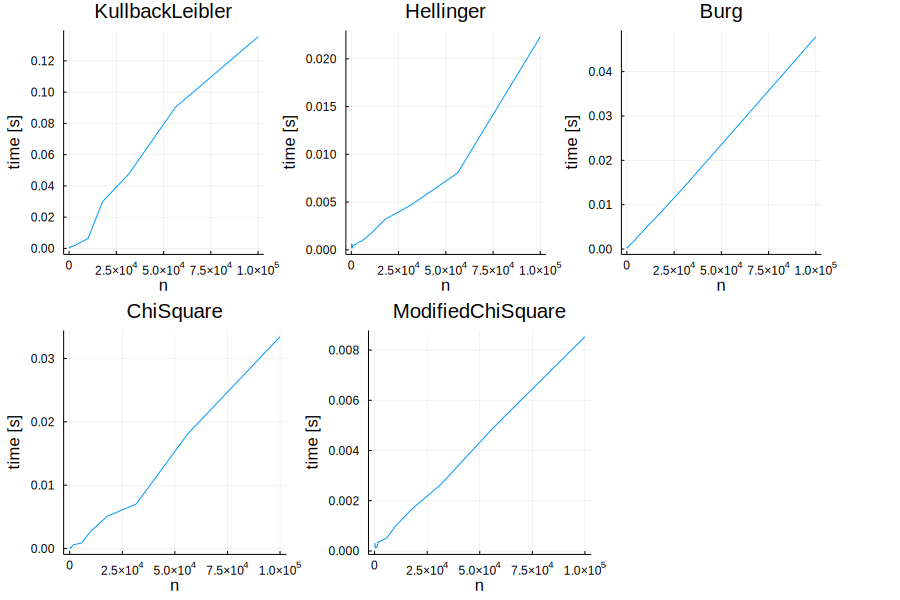

In [6]:
plots = Any[]
for d in [KullbackLeibler(), Hellinger(), Burg(), ChiSquare(), ModifiedChiSquare()]
    table = benchmark(Sadda(), (n) -> model_DRO(n, d), N; maxevals = 20, verbose = false)

    push!(plots, plot(table.dimension, table.evaltime_mean, title = string(typeof(d).name)))
end

plot(plots..., display = true,
               layout  = @layout([a{0.3w} b{0.3w} c{0.3w}; d{0.3w} e{0.3w}]),
               size    = (900, 600),
               legend  = false,
               xlabel  = "n",
               ylabel  = "time [s]")

## 2. Problem (DRO2)

Problem (DRO2) stems from the distributinally robust optimization and reads

$$
\begin{align*}
    \mathrm{maximize}
        \quad & \mathbf{c}^\top \mathbf{p} \\
    \mathrm{subject\ to}
        \quad & \sum_{i=1}^n p_i=1, \\
        \quad & 0 \le p_i, \quad \forall i = 1, \dots, n,\\
        \quad & \| \mathbf{p} - \mathbf{q}\|_{p} \le \varepsilon.
\end{align*}
$$

For the detailed problem derivation, please refer to our paper.

### 2.1. Solution properties

As in the case of (DRO1), the (DRO2) problem does not depend on the order of the components of $\mathbf{p}$ and without loss of generality we assume that $\mathbf{c}$ is sorted. For the comparison, we use the same random data previously generated for the (DRO1).

To keep the presentation simple, we compare our results only for the $l_{1}$ norm. In this case, we use the `CPLEX` solver for the comparison.

In [7]:
p_our   = solve(Sadda(), DRO(Lone(), q, c, ε));
p_cplex = solve(General(), DRO(Lone(), q, c, ε));

print(string("‖p_our - p_cplex‖ = ", LinearAlgebra.norm(p_our .- p_cplex)))

‖p_our - p_cplex‖ = 2.306595211858756e-16

Now we plot the obtained solutions for all three norms. As in the case of (DRO1), $\mathbf{p}$ is a probability distribution and an increase in one component has to lead to a decrease in another. Since the objective is linear and our aim is to maximize it, the solution will have small values of $p_i$ whenever $c_i$ is small and large values of $p_i$ whenever $c_i$ is large. This is shown in the next graph, where the values of the components of the vector $\mathbf{q}$ are denoted by blue circles and the values of the components of the optimal solution $\mathbf{p}$ are denoted by orange squares. Recall that $\mathbf{q}$ follows the uniform distribution and that $\mathbf{c}$ is sorted.

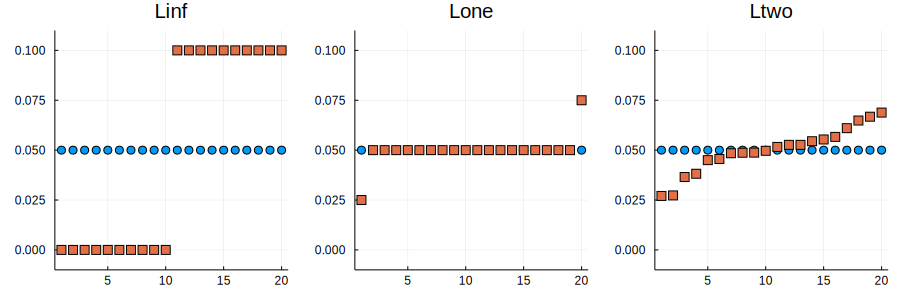

In [8]:
y_lims = Float64[]
plots  = Any[]
for d in [Linf(), Lone(), Ltwo()]
    p = solve(Sadda(), DRO(d, q, c, ε));

    f = plot(legend = :topleft, title = string(typeof(d).name))
    scatter!(1:n, q, marker = :circle)
    scatter!(1:n, p, marker = :rect)

    push!(y_lims, extrema(p)...)
    push!(plots, f)
end

plot(plots..., display = true,
               layout  = (1,3),
               legend = false,
               size    = (900, 300),
               ylims   = extrema(y_lims) .+ (-0.01, +0.01))

### 2.2. Time comparison
We provide the time complexity of the presented algorithms. Denoting $n$ to be the length of $\mathbf{q}$, we consider $n \in [10^{2},10^{5}]$.

In [9]:
l = 2:0.25:5;
N = ceil.(Int64, 10 .^l);

function model_DRO(n::Int, d, ε::Real = 0.1)
    q   = rand(n)
    q ./= sum(q)
    c   = rand(Distributions.Normal(0,1), n)
    
    return DRO(d, q, c, ε)
end;

For numerical comparison, we randomly generated the initial data $\mathbf{q}$, $\mathbf{c}$ for each $n$ and solved problem (DRO2). This was repeated twenty times and the results were averaged to remove random bias.

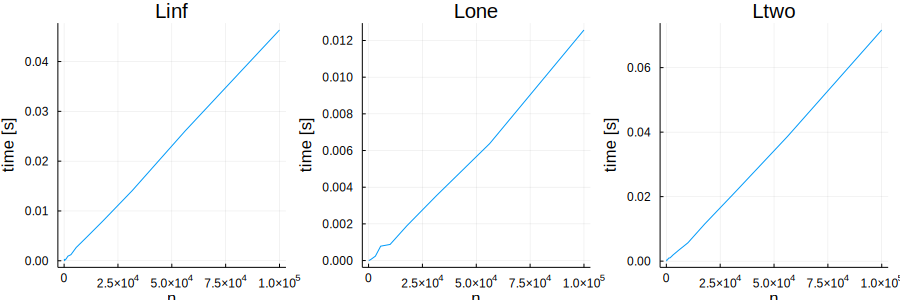

In [10]:
plots  = Any[]
for d in [Linf(), Lone(), Ltwo()]
    table = benchmark(Sadda(), (n) -> model_DRO(n, d), N; maxevals = 20, verbose = false)
    
    f = plot(table.dimension, table.evaltime_mean, title = string(typeof(d).name))
    push!(plots, f)
end

plot(plots..., display = true,
               layout  = (1,3),
               size    = (900, 300),
               legend  = false,
               xlabel  = "n",
               ylabel  = "time [s]")

In the figure above we see (almost) linear dependence of time on the data size $n$. For the $l_{2}$ norm we provide the comparison of our method and the algorithm from [[Philpott 2018]](https://link.springer.com/article/10.1007/s10287-018-0314-0). The computational complexity of `Philpott` is quadratic and the running time is much higher than ours. 

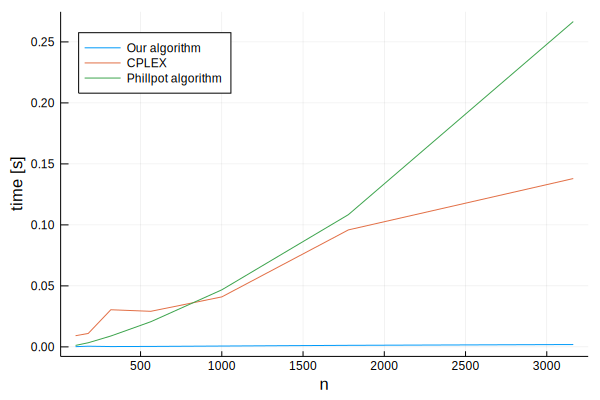

In [11]:
l = 2:0.25:3.5;
N = ceil.(Int64, 10 .^l);

plot()
table1 = benchmark(Sadda(), (n) -> model_DRO(n, Ltwo()), N; maxevals = 20, verbose = false)
plot!(table1.dimension, table1.evaltime_mean, label = "Our algorithm")
table2 = benchmark(General(), (n) -> model_DRO(n, Ltwo()), N; maxevals = 20, verbose = false)
plot!(table2.dimension, table2.evaltime_mean, label = "CPLEX")
table3 = benchmark(Philpott(), (n) -> model_DRO(n, Ltwo()), N; maxevals = 20, verbose = false)
plot!(table3.dimension, table3.evaltime_mean, label = "Phillpot algorithm")

plot!(display = true,
      legend  = :topleft,
      size    = (600, 400),
      xlabel  = "n",
      ylabel  = "time [s]")